
# Grouping Similar Questions
<img src="images/SpiceworksLogo.png" width="300px" style="float: right;"/>

#### Spiceworks Data Science


##### Natalie Durgin



Notebook: https://github.com/nataliedurgin/similar-questions

## Community Question Answering

#### Example Document 1

- **URL**: https://community.spiceworks.com/topic/328118
- **Subject**: need to unlock a password protected Excel 2010 workbook
- **Body**: I have a user who had forgotten the password for an Excel 2010 file.  She cannot open it.  I tried changing the name to a zip file and opening the workbook file with an xml editor, but I can't get a readable format to come up so I can see the line of text with the password (so I can delete it).  What I'm getting is this gobbledy-gook: ºʝZܡ M/ؽ(+蝤¤7

#### Example Document 2

- **URL**: https://community.spiceworks.com/topic/1766186
- **Subject**: Password protected Excel 2016 spreadsheet---user forgot password!
- **Body**: Face palm time.  A user has forgotten their password to an Excel 2016 spreadsheet. Anybody have any slick tool that will at least let them open in read-only mode?  Something to bust through the password would be excellent.

##### 2017 Survey
<a href= "https://arxiv.org/abs/1705.04009">A survey of Community Question Answering </a>

##### Main Reference
<a href= "http://www.aclweb.org/anthology/S17-2051"> SimBow at SemEval-2017 Task 3: Soft-Cosine Semantic Similarity between Questions for Community Question Answering </a>

##### Gensim Softcosine 
https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/soft_cosine_tutorial.ipynb

#### Example Document 3

- **URL**: https://community.spiceworks.com/topic/1984626
- **Subject**: How secure are password protected Excel files?
- **Body**: Once in a while if we need to send credentials to a third party we will use password protected Excel files sent via secure email (third party service where they have to login to see the email). I'm curious if the Excel file is secure enough by itself? Based on this info it looks like the default for Excel 2016 will be AES 256, which should be effectively secure at least against a brute force attack. \__url\__ "Lets you configure the CNG cipher algorithm that is used. The default is AES." " Lets you configure the number of bits to use when you create the cipher key. The default is 256 bits."

# Preprocessing

**Word**, **Term**, **Token** := Collection of characters 

**Document** := Collection of words

**Corpus** := Collection of documents

**Vocabulary** := Collection of distinct terms that appear in a corpus

Allowable collections depend upon preprocessing choices

## Preprocessing the Example Documents

We choose to concatenate subject and body 

In [225]:
doc1 = """need to unlock a password protected Excel 2010 workbook <p>I have a user who had forgotten the password for an Excel 2010 file.&nbsp; She cannot open it.&nbsp; I tried changing the name to a zip file and opening the workbook file with an xml editor, but I can&#39;t get a readable format to come up so I can see the line of text with the password (so I can delete it).&nbsp; What I&#39;m getting is this gobbledy-gook:</p><p>ºʝZܡ M/ؽ(+蝤¤7</p>"""
doc2 = """Password protected Excel 2016 spreadsheet---user forgot password! <p>Face palm time.  A user has forgotten their password to an Excel 2016 spreadsheet.<br><br>Anybody have any slick tool that will at least let them open in read-only mode?  Something to bust through the password would be excellent.</p>"""
doc3 = """How secure are password protected Excel files? <p>Once in a while if we need to send credentials to a third party we will use password protected Excel files sent via secure email (third party service where they have to login to see the email).<br><br></p><div>I'm curious if the Excel file is secure enough by itself? Based on this info it looks like the default for Excel 2016 will be AES 256, which should be effectively secure at least against a brute force attack.<div><a href="https://technet.microsoft.com/en-us/library/cc179125%28v=office.16%29.aspx?f=255&amp;MSPPError=-2147217396">https://technet.microsoft.com/en-us/library/cc179125%28v=office.16%29.aspx?f=255&amp;MSPPError=-2147...</a><br></div><div><ul><li><i>"Lets you configure the CNG cipher algorithm that is used. </i><b><i>The default is AES</i></b><i>."</i></li><li><i>"Lets you configure the number of bits to use when you create the cipher key. </i><b><i>The default is 256 bits</i></b><i>."</i></li></ul></div> </div>"""
docs = [doc1, doc2, doc3]
doc1

'need to unlock a password protected Excel 2010 workbook <p>I have a user who had forgotten the password for an Excel 2010 file.&nbsp; She cannot open it.&nbsp; I tried changing the name to a zip file and opening the workbook file with an xml editor, but I can&#39;t get a readable format to come up so I can see the line of text with the password (so I can delete it).&nbsp; What I&#39;m getting is this gobbledy-gook:</p><p>\xc2\xba\xca\x9d\xc2\x99Z\xdc\xa1 \xc2\x84M/\xd8\xbd(+\xe8\x9d\xa4\xc2\xa47</p>'

- Do you keep punctuation?
- Do you preserve letter case?
- Do you remove stopwords? 
- Do you impose minimum word frequencies? 
- Do you stem tokens?

Results can be sensitive to these choices to varying extents. These choices will likely be different for each corpus and application. 

## Gensim Default Preprocessing

In [226]:
import os
import gensim
DATA_DIR = 'data'

# Helper IO Function
def list2txt(doc_list, filename):
    filepath = os.path.join(DATA_DIR, filename)
    outfile = open(filepath, 'w')
    outfile.write("\n".join(doc_list))
    return filepath

default_target_corpus = gensim.corpora.TextCorpus(list2txt(docs, 'raw.txt'))

In [227]:
default_target_corpus.dictionary.items()
default_target_corpus.dictionary.id2token

{0: u'changing',
 1: u'come',
 2: u'delete',
 3: u'editor',
 4: u'excel',
 5: u'file',
 6: u'forgotten',
 7: u'format',
 8: u'getting',
 9: u'gobbledy',
 10: u'gook',
 11: u'line',
 12: u'nbsp',
 13: u'need',
 14: u'open',
 15: u'opening',
 16: u'password',
 17: u'protected',
 18: u'readable',
 19: u'text',
 20: u'tried',
 21: u'unlock',
 22: u'user',
 23: u'workbook',
 24: u'xml',
 25: u'zip',
 26: u'anybody',
 27: u'bust',
 28: u'excellent',
 29: u'face',
 30: u'forgot',
 31: u'let',
 32: u'mode',
 33: u'palm',
 34: u'read',
 35: u'slick',
 36: u'spreadsheet',
 37: u'time',
 38: u'tool',
 39: u'aes',
 40: u'algorithm',
 41: u'amp',
 42: u'aspx',
 43: u'attack',
 44: u'based',
 45: u'bits',
 46: u'brute',
 47: u'cipher',
 48: u'cng',
 49: u'com',
 50: u'configure',
 51: u'create',
 52: u'credentials',
 53: u'curious',
 54: u'default',
 55: u'div',
 56: u'effectively',
 57: u'email',
 58: u'files',
 59: u'force',
 60: u'href',
 61: u'https',
 62: u'info',
 63: u'key',
 64: u'lets',
 65

Default preprocessing gotchas:
- Filters out words shorter than three characters (e.g. IT, MS, IP, 64, GB, PC, sw etc.)
- Aggressive stopword list? 
- No numbers? (2010, v0.1 etc.)

## Custom Preprocessing

In [228]:
import re # python regular expression library
import bs4 # python html parsing library "beautiful soup" 

# Sample custom preprocessing sequence
DELIMITER_PATTERN = u'[!?,;:\t\\\\"\\(\\)\\\'\u2026\u201c\u2013\u2019\u2026\n]|\\s\\-\\s|\.\s'
TOKEN_PATTERN = r'(?u)[\_][a-zA-Z0-9\_]*|[a-zA-Z0-9][a-zA-Z0-9.]*\b'

def html_parser(html):
    try:
        html = re.sub(r"<img.*?>", " __img__ ", html)
        html = re.sub(r"< .*?/a>", " __url__ ", html)
        soup = bs4.BeautifulSoup(html, "html.parser")
        for br in soup.find_all("br"):
            br.replace_with("\n")
        return soup.get_text()
    except:  
        return ''
    
def split_sentences(doc):
    try:
        delimiters = re.compile(DELIMITER_PATTERN)
        sentences = delimiters.split(doc)
        return sentences
    except:
        return []

def tokenizer(sentence, token_pattern=TOKEN_PATTERN, lowercase=True):
    try:
        token_pattern = re.compile(token_pattern)
        if lowercase:
            sentence = sentence.lower()
        return token_pattern.findall(sentence)

    except:
        return []

def clean_text(html, lowercase=True):
    text = html_parser(html)
    if lowercase:
        text = text.lower()

    sents = split_sentences(text)
    sents = [' '.join(tokenizer(sent, lowercase=lowercase)) for sent in sents]
    try:
        sents = map(lambda x: x.strip(), sents)
    except:
        pass
    try:
        sents = [sent for sent in sents if len(sent) > 0]
    except:
        pass
    return ' '.join(sents)

In [229]:
doc3

'How secure are password protected Excel files? <p>Once in a while if we need to send credentials to a third party we will use password protected Excel files sent via secure email (third party service where they have to login to see the email).<br><br></p><div>I\'m curious if the Excel file is secure enough by itself? Based on this info it looks like the default for Excel 2016 will be AES 256, which should be effectively secure at least against a brute force attack.<div><a href="https://technet.microsoft.com/en-us/library/cc179125%28v=office.16%29.aspx?f=255&amp;MSPPError=-2147217396">https://technet.microsoft.com/en-us/library/cc179125%28v=office.16%29.aspx?f=255&amp;MSPPError=-2147...</a><br></div><div><ul><li><i>"Lets you configure the CNG cipher algorithm that is used. </i><b><i>The default is AES</i></b><i>."</i></li><li><i>"Lets you configure the number of bits to use when you create the cipher key. </i><b><i>The default is 256 bits</i></b><i>."</i></li></ul></div>\xc2\xa0</div>'

In [230]:
clean_text(doc3)

u'how secure are password protected excel files once in a while if we need to send credentials to a third party we will use password protected excel files sent via secure email third party service where they have to login to see the email i m curious if the excel file is secure enough by itself based on this info it looks like the default for excel 2016 will be aes 256 which should be effectively secure at least against a brute force attack.https technet.microsoft.com en us library cc179125 28v office.16 29.aspx f 255 mspperror 2147 lets you configure the cng cipher algorithm that is used the default is aes lets you configure the number of bits to use when you create the cipher key the default is 256 bits'

In [231]:
# Subclass gensim TextCorpus object to apply custom preprocesing
# Preprocessing functions need to be efficient if performance is a concern!
class CustomTextCorpus(gensim.corpora.TextCorpus):
  def get_texts(self):
    for doc in self.getstream():
        yield [word for word in clean_text(doc).split()]
  def __len__(self): 
    self.length = sum(1 for _ in self.get_texts())
    return self.length

preprocessed_docs = [clean_text(doc) for doc in docs]
custom_target_corpus = CustomTextCorpus(list2txt(preprocessed_docs, 'preprocessed.txt'))

In [232]:
custom_target_corpus.dictionary.items()
custom_target_corpus.dictionary.id2token

{0: u'2010',
 1: u'7',
 2: u'a',
 3: u'an',
 4: u'and',
 5: u'but',
 6: u'can',
 7: u'cannot',
 8: u'changing',
 9: u'come',
 10: u'delete',
 11: u'editor',
 12: u'excel',
 13: u'file',
 14: u'for',
 15: u'forgotten',
 16: u'format',
 17: u'get',
 18: u'getting',
 19: u'gobbledy',
 20: u'gook',
 21: u'had',
 22: u'have',
 23: u'i',
 24: u'is',
 25: u'it',
 26: u'line',
 27: u'm',
 28: u'name',
 29: u'need',
 30: u'of',
 31: u'open',
 32: u'opening',
 33: u'password',
 34: u'protected',
 35: u'readable',
 36: u'see',
 37: u'she',
 38: u'so',
 39: u't',
 40: u'text',
 41: u'the',
 42: u'this',
 43: u'to',
 44: u'tried',
 45: u'unlock',
 46: u'up',
 47: u'user',
 48: u'what',
 49: u'who',
 50: u'with',
 51: u'workbook',
 52: u'xml',
 53: u'zip',
 54: u'2016',
 55: u'any',
 56: u'anybody',
 57: u'at',
 58: u'be',
 59: u'bust',
 60: u'excellent',
 61: u'face',
 62: u'forgot',
 63: u'has',
 64: u'in',
 65: u'least',
 66: u'let',
 67: u'mode',
 68: u'only',
 69: u'palm',
 70: u'read',
 71: u'

# Documents and their Vector Space Representations

## Word Count Vectors

A gensim corpus object is an iterable of list of (int, num)

In [233]:
TARGET_CORPUS = default_target_corpus
doc_vectors = [word_count_vector for word_count_vector in TARGET_CORPUS]
doc_vector = doc_vectors[1]
doc_vector

[(4, 2),
 (6, 1),
 (14, 1),
 (16, 4),
 (17, 1),
 (22, 2),
 (26, 1),
 (27, 1),
 (28, 1),
 (29, 1),
 (30, 1),
 (31, 1),
 (32, 1),
 (33, 1),
 (34, 1),
 (35, 1),
 (36, 2),
 (37, 1),
 (38, 1)]

In [234]:
# Make Pandas dataframe preview font larger
# Set CSS properties for th elements in dataframe
# Set CSS properties for td elements in dataframe
# Set table display styles
styles = [
  dict(selector="th", props=[('font-size', '30px')]),
  dict(selector="td", props=[('font-size','30px')])
  ]

In [235]:
import pandas as pd
pd.DataFrame([(k,v,TARGET_CORPUS.dictionary.id2token[k]) for k,v in doc_vector], 
             columns=['vocab_index', 'word_count', 'token']).style.set_table_styles(styles)

,vocab_index,word_count,token
0,4,2,excel
1,6,1,forgotten
2,14,1,open
3,16,4,password
4,17,1,protected
5,22,2,user
6,26,1,anybody
7,27,1,bust
8,28,1,excellent
9,29,1,face


## TF-IDF Vectors

TF-IDF = Term Frequency-Inverse Document Frequency 

https://en.wikipedia.org/wiki/Tf-idf

Discount the frequency of terms common to many documents in the (training/target) corpus. 

In [236]:
# IDF's coming from the small target corpus
def get_target_tfidf(target_corpus):
    return gensim.models.TfidfModel(target_corpus, dictionary=target_corpus.dictionary)[target_corpus]

iter(get_target_tfidf(default_target_corpus)).next()

[(0, 0.18027306351311892),
 (1, 0.18027306351311892),
 (2, 0.18027306351311892),
 (3, 0.18027306351311892),
 (5, 0.1996002719256453),
 (6, 0.0665334239752151),
 (7, 0.18027306351311892),
 (8, 0.18027306351311892),
 (9, 0.18027306351311892),
 (10, 0.18027306351311892),
 (11, 0.18027306351311892),
 (12, 0.5408191905393568),
 (13, 0.0665334239752151),
 (14, 0.0665334239752151),
 (15, 0.18027306351311892),
 (18, 0.18027306351311892),
 (19, 0.18027306351311892),
 (20, 0.18027306351311892),
 (21, 0.18027306351311892),
 (22, 0.0665334239752151),
 (23, 0.36054612702623784),
 (24, 0.18027306351311892),
 (25, 0.18027306351311892)]

In [237]:
# Term mapping logic
# Subclass the corpus transormation interface
class MapTermIds(gensim.interfaces.TransformationABC):
  def __init__(self, termid_map):
      self.termid_map = termid_map

  def __getitem__(self, bow):
      is_corpus, bow = gensim.utils.is_corpus(bow)
      if is_corpus:
          return self._apply(bow)

      vector = [(self.termid_map.get(termid), weight)
                for termid, weight in bow if self.termid_map.get(termid)]
      return vector

In [238]:
def create_compatible_termid_maps(target_dictionary, training_dictionary):
    token_training_map = training_dictionary.token2id
    target_training_map = {k: token_training_map.get(v) for k, v
                       in target_dictionary.iteritems()}
    missing_indices = [k for k, v in target_training_map.iteritems() if not v]
    target_dictionary.filter_tokens(missing_indices)
    
    # Remove terms not found in the training dictionary
    target_dictionary.compactify() 

    target_training_map = {k: token_training_map.get(v) for k, v
                       in target_dictionary.iteritems()}
    training_target_map = {v: k for k, v in target_training_map.iteritems()}
    target_training_transform = MapTermIds(target_training_map)
    training_target_transform = MapTermIds(training_target_map)

    return target_dictionary, target_training_transform, training_target_transform

In [239]:
# Uses custom method "create_compatible_termid_maps"
# IDF's coming from the large training corpus
def get_training_tfidf(target_corpus):
    training_tfidf = gensim.models.TfidfModel.load('models/posts_parsed_text.tfidf')
    training_dictionary = gensim.corpora.Dictionary.load(
        os.path.join(DATA_DIR, 'posts_parsed_text.dict'))
    target_dictionary, target_training_transform, training_target_transform = \
        create_compatible_termid_maps(target_corpus.dictionary, training_dictionary)
    return training_target_transform[
        training_tfidf[
            target_training_transform[
                target_corpus]]]


iter(get_training_tfidf(default_target_corpus)).next()

[(1, 0.07473674755927918),
 (2, 0.09200057163139172),
 (3, 0.13275710823384462),
 (4, 0.21101504992672906),
 (5, 0.1961408770877077),
 (6, 0.14156305707543346),
 (7, 0.10845870953425936),
 (8, 0.06585867821235018),
 (9, 0.27237547353737984),
 (10, 0.2364510047341792),
 (11, 0.08207047632413615),
 (12, 0.6235888690447704),
 (13, 0.04436301952147567),
 (14, 0.07219695476235263),
 (15, 0.11180220841097105),
 (16, 0.24650265310704142),
 (17, 0.1267836592437009),
 (18, 0.16594137798421438),
 (19, 0.09988745088314074),
 (20, 0.07386295088617181),
 (21, 0.14034464090874477),
 (22, 0.05435583471519226),
 (23, 0.34089112777540964),
 (24, 0.13566354175600648),
 (25, 0.1311927519650724)]

In [240]:
# Note, gensim will eliminate terms that appear in every document
# This probably is not a concern when you are dealing with even slightly larger corpora 
test_docs = ['foo', 'foo bar', 'foo bar baz']
test_texts = [[word for word in doc.lower().split()] for doc in test_docs]
test_dict = gensim.corpora.Dictionary(test_texts)
test_corpus = [test_dict.doc2bow(text) for text in test_texts]
test_tfidf = gensim.models.TfidfModel(test_corpus)
[doc for doc in test_tfidf[test_corpus]]

[[], [(1, 1.0)], [(1, 0.34624155305796134), (2, 0.9381453975456102)]]

## Weighted-Average of Word Vectors 

### Tf-idf document representation:  
$$
\left(
\begin{array}{r|l}
\text{"come"} & 0.075\\
\text{"delete"} & 0.092\\
\text{"editor"} & 0.133\\
\text{"excel"} & 0.211\\
\text{"file"} & 0.196\\
\end{array}
\right)
$$

### If you had a vector representation of words...
$$
\left(
\begin{array}{r|l}
\text{"come"} & (0.1, \ldots, 0.5)\\
\text{"delete"} & (0.3, \ldots, 0.2)\\
\text{"editor"} & (0.1, \ldots, 0.4)\\
\text{"excel"} & (0.6, \ldots, 0.2)\\
\text{"file"} & (0.1, \ldots, 0.3)\\
\end{array}
\right)
$$

### Weighted-average of word vectors:

$$
\text{"come" } 0.075 \begin{pmatrix} 0.1\\ \vdots\\ 0.5\end{pmatrix} + \text{"delete" }0.092 \begin{pmatrix}0.3\\ \vdots\\ 0.2 \end{pmatrix} + \text{"editor" }0.133\begin{pmatrix} 0.1\\ \vdots\\ 0.4\end{pmatrix} + \\
\ldots \text{"excel" }0.211\begin{pmatrix} 0.6\\ \vdots\\ 0.2\end{pmatrix} + \text{"file" }0.196\begin{pmatrix} 0.1\\ \vdots\\ 0.3\end{pmatrix}
$$

Get another vector representation of a document.

The audience is probably familiar with ways to obtain word vectors... 

# Words and their Vector Space Representations

#### Note:
- Speaker models: trained on Spiceworks Community custom pre-processed corpus 
- Audience models: stubs from the gensim test repo; included so some cells will compile
- Please train your own models for meaningful results
- For more on training your own models using gensim see, for example: http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code

In [241]:
# For Audience: 
# import gensim.test.utils
# w2v_path = gensim.test.utils.datapath('word2vec_old')
# w2v = gensim.models.Word2Vec.load(w2v_path)
# ftx_path = gensim.test.utils.datapath('fasttext_old')
# ftx = gensim.models.FastText.load(ftx_path)

# For Speaker:
#skip-gram, min_count=20, size=200, window=10
w2v = gensim.models.Word2Vec.load("models/word2vec_model_unigram_lowercase")
ftx = gensim.models.FastText.load("models/fasttext_model_unigram_lowercase")

In [242]:
w2v.wv.most_similar('computer', topn=10)

[(u'pc', 0.804652214050293),
 (u'machine', 0.7396371364593506),
 (u'workstation', 0.687087893486023),
 (u'laptop', 0.6701804399490356),
 (u'computers', 0.6077813506126404),
 (u'printer', 0.5282449722290039),
 (u'desktop', 0.5122043490409851),
 (u'device', 0.470727801322937),
 (u'pcand', 0.462885320186615),
 (u'pcs', 0.4616956114768982)]

In [243]:
ftx.wv.most_similar('computer', topn=10)

[(u'acomputer', 0.9429256916046143),
 (u'scomputer', 0.9186970591545105),
 (u'tocomputer', 0.9176599383354187),
 (u'computer4', 0.9165210127830505),
 (u'computeri', 0.9112850427627563),
 (u'komputer', 0.9096609354019165),
 (u'minicomputer', 0.9090799689292908),
 (u'computerin', 0.9068394303321838),
 (u'colcomputer', 0.9036481976509094),
 (u'computer3', 0.9017834663391113)]

In [244]:
w2v.wv["excel"]

array([ 4.0282183 ,  1.2013625 , -1.3921268 ,  0.8217582 ,  1.5519204 ,
        0.844429  ,  5.9267664 ,  2.5641832 , -4.6224465 ,  1.3624501 ,
       -5.061894  , -5.43022   ,  2.5380747 ,  2.8784335 ,  1.3708048 ,
        0.6266576 , -4.250798  , -2.3694801 , -2.706934  ,  0.65685004,
       -0.05581836,  0.06307846, -0.29421508, -1.1435201 , -3.6387348 ,
        1.7892005 , -1.147864  , -5.599832  , -0.62359476,  1.970613  ,
        2.1880927 , -0.2966052 ,  1.2801863 , -3.3769345 ,  2.1860697 ,
        2.68782   ,  3.9020295 , -5.001813  ,  4.845451  , -1.6881222 ,
        0.61382407, -3.2506828 ,  0.5206685 , -1.7164947 ,  0.16390201,
       -0.68463844,  0.10834248, -0.77222353, -5.5950685 , -2.3295124 ,
        1.8326058 ,  3.9277148 ,  2.4197507 ,  2.7926948 , -0.83345634,
        0.3857129 , -0.39134166,  1.8342378 , -7.4511786 ,  6.7927704 ,
        0.12419615,  0.7974883 , -2.3099947 , -6.5153136 , -4.465302  ,
        3.345026  , -0.55666965, -3.5195887 , -1.7074724 , -0.66

# Question Similarity

## Dot Product
- $N$: Size of the vocabulary 
- $X_1, X_2$: Document vectors, $N\times 1$ dimensional  

Sum of the pairwise products,

\begin{eqnarray*}
X_1\cdot X_2 &=& \begin{pmatrix}X_{11} \\ \vdots \\ X_{1N}\end{pmatrix} \cdot \begin{pmatrix}X_{21} \\ \vdots \\ X_{2N}\end{pmatrix} = \sum_{i=1}^N X_{1i}(X_{2i})\\
&=& X_{11} (X_{21}) + X_{12}(X_{22}) + \cdots + X_{1N}(X_{2N}).
\end{eqnarray*}

$$\begin{pmatrix}1 \\ 2 \\ 3 \end{pmatrix} \cdot \begin{pmatrix} 0\\ 1\\ 1 \end{pmatrix} = 1(0)+2(1)+3(1)=5.$$

In [245]:
import scipy as sp
sp.dot([1,0],[0,1])

0

## Cosine Similarity

\begin{eqnarray} 
\cos(X_1, X_2) &=& \frac{X_1\cdot X_2}{||X_1||\text{ }||X_2||}\\
               &=& \frac{X_1^T X_2}{\sqrt{X_1^T X_1}\sqrt{X_2^T X_2}}
\end{eqnarray}


### Custom Word Count Vectors

In [246]:
cosim_index = gensim.similarities.MatrixSimilarity(custom_target_corpus)
cosim_index[custom_target_corpus]

array([[1.        , 0.34612355, 0.45574644],
       [0.34612355, 1.        , 0.35105228],
       [0.45574644, 0.35105228, 1.0000001 ]], dtype=float32)

### Custom Tf-idf Vectors 
With the idfs coming from the small target corpus

In [247]:
target_tfidf = get_target_tfidf(custom_target_corpus)
cosim_index = gensim.similarities.MatrixSimilarity(target_tfidf)
cosim_index[target_tfidf]

array([[0.99999994, 0.02023492, 0.03237899],
       [0.02023492, 0.9999999 , 0.02258889],
       [0.03237899, 0.02258889, 1.        ]], dtype=float32)

### Custom Tf-idf Vectors
With the idfs from the large training corpus

In [248]:
target_corpus = custom_target_corpus
training_tfidf = get_training_tfidf(target_corpus)
cosim_index = gensim.similarities.MatrixSimilarity(training_tfidf)
cosim_index[training_tfidf]

array([[1.        , 0.2963984 , 0.17173567],
       [0.2963984 , 1.        , 0.22083548],
       [0.17173567, 0.22083548, 1.        ]], dtype=float32)

In [249]:
cosim_index = gensim.similarities.MatrixSimilarity(default_target_corpus)
cosim_index[default_target_corpus]

array([[1.        , 0.42794803, 0.19976044],
       [0.42794803, 1.        , 0.205169  ],
       [0.19976044, 0.205169  , 1.        ]], dtype=float32)

In [250]:
target_tfidf = get_target_tfidf(default_target_corpus)
cosim_index = gensim.similarities.MatrixSimilarity(target_tfidf)
cosim_index[target_tfidf]

array([[1.        , 0.02395141, 0.00793372],
       [0.02395141, 1.        , 0.        ],
       [0.00793372, 0.        , 1.        ]], dtype=float32)

Notice that document 2 and 3 have 0 term overlap. 

Problematic? What about these two sentences: 

1. "Fix broken laptop."
2. "Troubleshoot crashed computer."

These sentences have zero term overlap, but express related meanings. They are "semantically similar". 

In [251]:
target_corpus = default_target_corpus
training_tfidf = get_training_tfidf(target_corpus)
cosim_index = gensim.similarities.MatrixSimilarity(training_tfidf)
cosim_index[training_tfidf]

array([[1.        , 0.26191717, 0.10925236],
       [0.26191717, 1.        , 0.16283868],
       [0.10925236, 0.16283868, 1.        ]], dtype=float32)

### Cosine similarity of word vectors

TODO: formula from paper for cosine similarity of words...

In [252]:
wv_computer = w2v.wv['computer']
wv_pc = w2v.wv['pc']
sp.dot(wv_computer, wv_pc)/(sp.sqrt(sp.dot(wv_computer, wv_computer))* sp.sqrt(sp.dot(wv_pc, wv_pc)))

0.8046523

In [253]:
w2v.wv.most_similar('computer', topn=1)

[(u'pc', 0.804652214050293)]

In [254]:
# Display a term-similarity matrix as a pandas dataframe indexed by the terms 
def display_term_similarities(term_dict, M):
    terms = [term_dict[k] for k in sorted(term_dict.iterkeys())]
    return pd.DataFrame(M.todense(), 
             index=terms, 
             columns=terms).style.set_table_styles(styles)

### Term Similarity Matrix

Gensim word embedding vectors have a *similarity matrix* feature:

    gensim.models.keyedvectors.similarity_matrix()

In [255]:
dict_stub = {0: "broken", 1: "fix", 2:"laptop", 3:"computer", 4:"crashed", 5:"troubleshoot"}
M_eg = w2v.wv.similarity_matrix(dict_stub)
display_term_similarities(dict_stub, M_eg) 

,broken,fix,laptop,computer,crashed,troubleshoot
broken,1,0.0835181,0.0143308,0.0166764,0.126778,0.0100578
fix,0.0835181,1,0.0156713,0.0323089,0.059446,0.429156
laptop,0.0143308,0.0156713,1,0.449142,0.0468678,0.00492678
computer,0.0166764,0.0323089,0.449142,1,0.0202786,0.0171988
crashed,0.126778,0.059446,0.0468678,0.0202786,1,0.0169646
troubleshoot,0.0100578,0.429156,0.00492678,0.0171988,0.0169646,1


In [256]:
target_corpus = custom_target_corpus
M_w2v = w2v.wv.similarity_matrix(target_corpus.dictionary)
M_ftx = ftx.wv.similarity_matrix(target_corpus.dictionary)
display_term_similarities(target_corpus.dictionary, M_ftx)

limit_output extension: Maximum message size of 10000 exceeded with 2053843 characters

## Soft Cosine Similarity
$M$: Term-similarity matrix, $N\times N$ dimensional

$$ \cos_M (X_1, X_2) = \frac{X_1^T M X_2}{\sqrt{X_1^T M X_1}\sqrt{X_2^T M X_2}}$$

In [257]:
target_corpus = custom_target_corpus
training_tfidf = get_training_tfidf(target_corpus)
doc_w2vsim_index = gensim.similarities.SoftCosineSimilarity(training_tfidf, M_w2v)
doc_ftxsim_index = gensim.similarities.SoftCosineSimilarity(training_tfidf, M_ftx)

In [258]:
# Current master branch now accepts corpus object instead of a list
print(doc_w2vsim_index[[bow for bow in training_tfidf]])

[[1.         0.43940267 0.26646875]
 [0.43940267 1.         0.28200864]
 [0.26646873 0.28200864 1.        ]]


In [259]:
print(doc_ftxsim_index[[bow for bow in training_tfidf]])

[[1.         0.43139103 0.25524559]
 [0.43139106 1.         0.28962182]
 [0.25524562 0.28962182 1.        ]]


# Supervised Model

## Score Variations

### Preprocessing 
- Default, Custom, Variations

### Target Corpus
- Questions, Topics, Posts, Subjects, Combinations

### Training Corpus
- Community,  Serverfault, Superuser

### Word  Vector 
- Characters,  Fasttext,  Word2vec, Various Parameters

### Document Vector
- Word Count, Tf-idf, Weighted-Avg Word2vec

### Word  Similarity
- Levenstein, Cosine

### Document Similarity 
- Cosine, Softcosine

## Model Setup
$$
\begin{array}{r|llll}
                   & \cos_{M_{w2v}} & \cos_{M_{ftx}} & \cos_{M_{lev}} & \textbf{label}\\\hline
\textbf{doc1, doc2} & 0.55085301 & 0.64283401 & \cdots & 1\\
\textbf{doc1, doc3} & 0.40678137 & 0.52912646 & \cdots & 0 \\
\textbf{doc2, doc3} & 0.37607284 & 0.49222433 & \cdots & 0
\end{array}
$$

- Train some standard regressors on selected features to obtain a final score
- Leverage Human-in-the-Loop patterns to grow repository of training data


# Question Clustering

Once we have document similarity scores, how do we choose what goes together? 

View as weighted edges in a graph:

$$
\begin{array}{r|l}
                      & \cos_{M_{w2v}}\\\hline
\textbf{(doc1, doc2)} & 0.55085301 \\
\textbf{(doc1, doc3)} & 0.40678137 \\
\textbf{(doc2, doc3)} & 0.37607284
\end{array}
$$

In [260]:
doc_w2vsim = doc_w2vsim_index[[bow for bow in training_tfidf]]
w2vsim_df = pd.DataFrame([[1, 2, doc_w2vsim[0,1]],
                          [1, 3, doc_w2vsim[0,2]],
                          [2, 3, doc_w2vsim[1,2]]], 
                         columns=["s", "f", "weight"])

import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
G=nx.Graph()
G.add_weighted_edges_from(w2vsim_df.values)

(-1.0334074806943085,
 1.1338368790860103,
 -0.7386912427851797,
 1.1589735901857394)

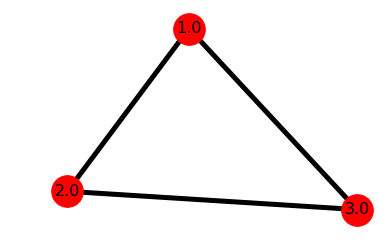

In [261]:
pos=nx.spring_layout(G)

nx.draw_networkx_edges(G,pos, edgelist=G.edges, width=5, arrowsize=100)
nx.draw_networkx_nodes(G,pos, node_size=1000)
nx.draw_networkx_labels(G,pos, font_size=16)
plt.axis('off')

# Business Impact

## Impact of Curating Similar Questions

Preliminary experiments showed **30-40% lift in engagement** (pageviews per unique, per week) by conveniently showing users answers to similar questions asked on the site. 

## Impact of Improving the Model

- Semi-manually vetted clusters: **23% lift in engagement** 
- Unvetted clusters: **16% lift in engagement** 

(*Early Data*)

# Future Work

- Add text from relevant Stackexchange API's to training corpus (e.g. serverfault, superuser etc.)
- Train supervised model
- Alternative clustering algorithms

<img src="images/top_10_graph.png" width="1000px" style="float: top;"/>